### Загрузка датасета COCO и кода COCO API
Необходимо раскомментировать код ниже. В нём происходит скачивание и распаковка датасета COCO.
Кроме того, здесь клонируется репозиторий с кодом COCO API (код для работы с данными из COCO)

Запускать лучше всего в Google Cloab или на другой Linux-машине

In [ ]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

### Импорт необходимых библиотек

In [1]:
import os
import skimage.io as io
import numpy as np
import tensorflow as tf
# tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)
import sys
sys.path.insert(0, 'C:\\Users\\avdee\\Documents\\python\\coco\\PythonAPI')

TensorFlow version: 2.4.0


### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [2]:
from pycocotools.coco import COCO

class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [3]:
COCO_ROOT = 'C:\\Users\\avdee\\Documents\\python\\coco'

In [4]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [5]:
BATCH_SIZE = 4
EPOCHS = 30
IMG_SIZE = 256

In [6]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

train_ds = COCO_dataset_train.train_dataset(BATCH_SIZE, EPOCHS, IMG_SIZE)
val_ds = COCO_dataset_val.val_dataset(BATCH_SIZE, IMG_SIZE)

loading annotations into memory...
Done (t=20.77s)
creating index...
index created!
loading annotations into memory...
Done (t=2.22s)
creating index...
index created!


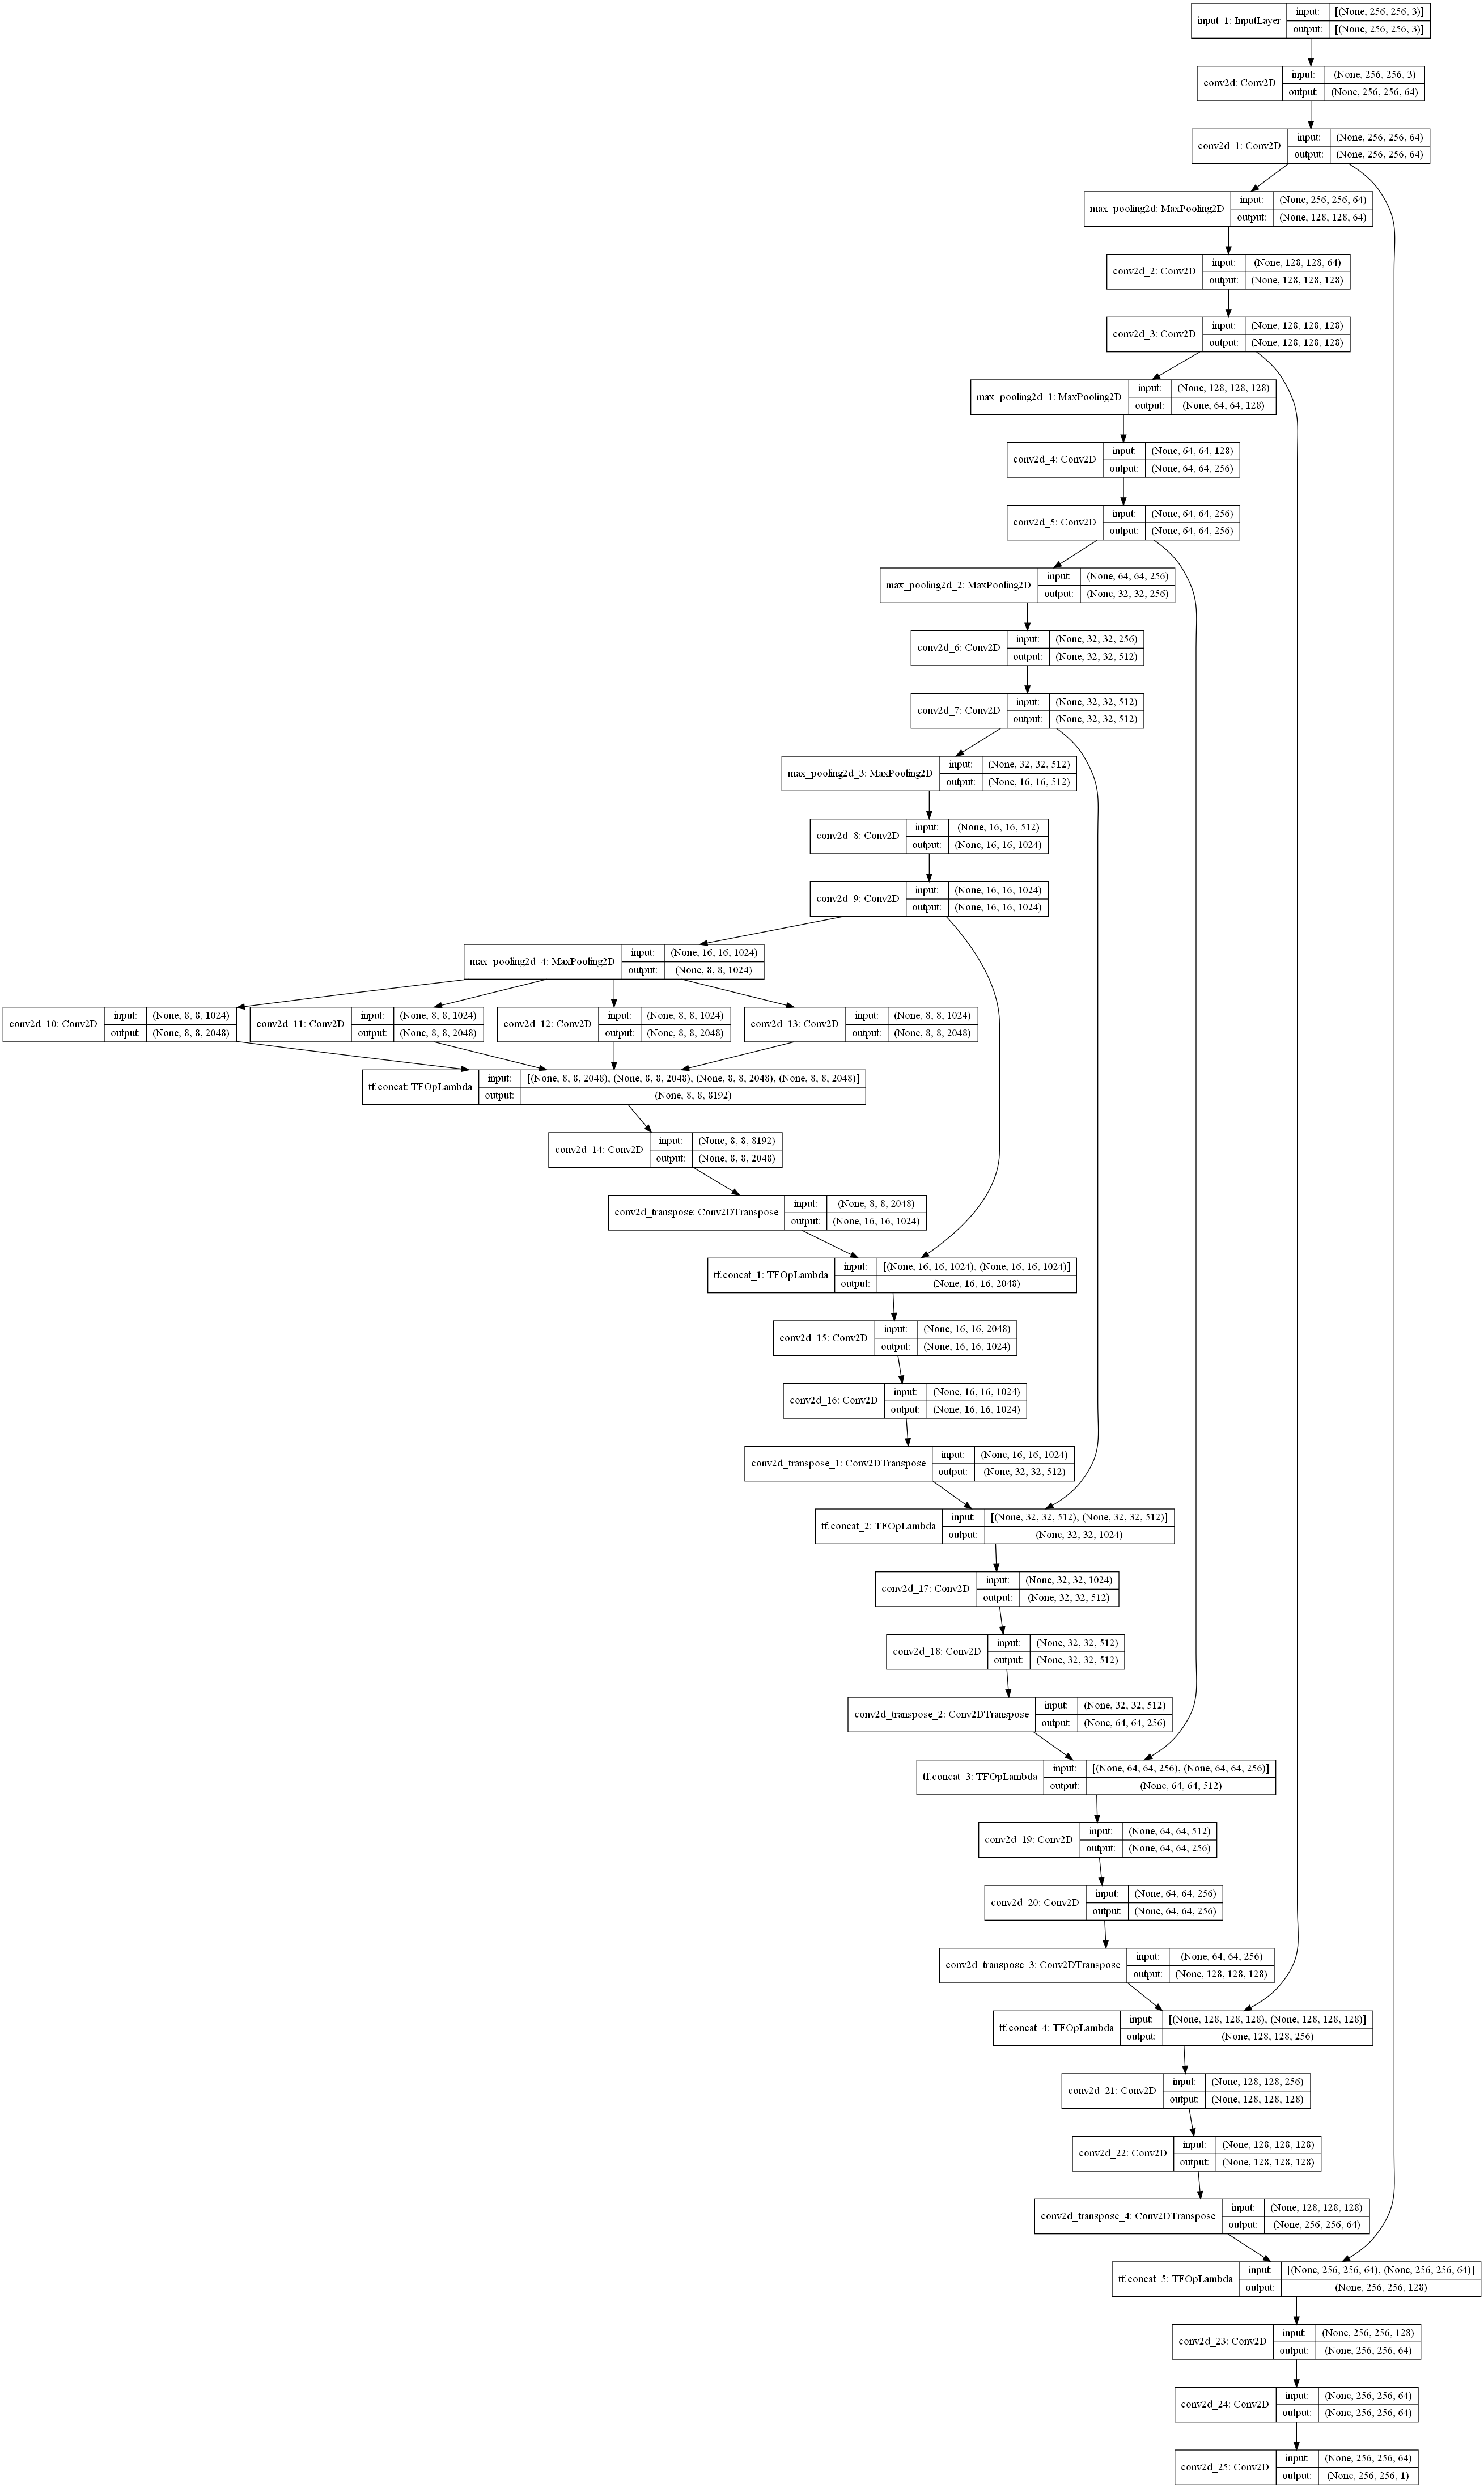

In [7]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model


inp = Input((256, 256, 3))

out = Conv2D(64, (3, 3), padding='same', activation='relu')(inp)
out1 = Conv2D(64, (3, 3), padding='same', activation='relu')(out)

out = tf.keras.layers.MaxPool2D((2, 2))(out1)
out = Conv2D(128, (3, 3), padding='same', activation='relu')(out)
out2 = Conv2D(128, (3, 3), padding='same', activation='relu')(out)

out = tf.keras.layers.MaxPool2D((2, 2))(out2)
out = Conv2D(256, (3, 3), padding='same', activation='relu')(out)
out3 = Conv2D(256, (3, 3), padding='same', activation='relu')(out)

out = tf.keras.layers.MaxPool2D((2, 2))(out3)
out = Conv2D(512, (3, 3), padding='same', activation='relu')(out)
out4 = Conv2D(512, (3, 3), padding='same', activation='relu')(out)

out = tf.keras.layers.MaxPool2D((2, 2))(out4)
out = Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
out5 = Conv2D(1024, (3, 3), padding='same', activation='relu')(out)


out = tf.keras.layers.MaxPool2D((2, 2))(out5)

aspp1 = Conv2D(2048, (3, 3), padding='same', activation='relu')(out)
aspp2 = Conv2D(2048, (3, 3), dilation_rate=6, padding='same', activation='relu')(out)
aspp3 = Conv2D(2048, (3, 3), dilation_rate=12, padding='same', activation='relu')(out)
aspp4 = Conv2D(2048, (3, 3), dilation_rate=18, padding='same', activation='relu')(out)

out = tf.concat([aspp1, aspp2, aspp3, aspp4], axis=3)
out = Conv2D(2048, (3, 3), padding='same', activation='relu')(out)


out = Conv2DTranspose(1024, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
out = tf.concat([out5, out], axis=3)
out = Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
out = Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

out = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
out = tf.concat([out4, out], axis=3)
out = Conv2D(512, (3, 3), padding='same', activation='relu')(out)
out = Conv2D(512, (3, 3), padding='same', activation='relu')(out)

out = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
out = tf.concat([out3, out], axis=3)
out = Conv2D(256, (3, 3), padding='same', activation='relu')(out)
out = Conv2D(256, (3, 3), padding='same', activation='relu')(out)

out = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
out = tf.concat([out2, out], axis=3)
out = Conv2D(128, (3, 3), padding='same', activation='relu')(out)
out = Conv2D(128, (3, 3), padding='same', activation='relu')(out)

out = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
out = tf.concat([out1, out], axis=3)
out = Conv2D(64, (3, 3), padding='same', activation='relu')(out)
out = Conv2D(64, (3, 3), padding='same', activation='relu')(out)

out = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

model = Model(inp, out)

plot_model(model, show_shapes=True)

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=40)

Epoch 1/30
40/40 [==============================] - 51s 906ms/step - loss: 0.5962 - accuracy: 0.7732
Epoch 2/30
40/40 [==============================] - 36s 896ms/step - loss: 0.5409 - accuracy: 0.7692
Epoch 3/30
40/40 [==============================] - 37s 930ms/step - loss: 0.4986 - accuracy: 0.7859
Epoch 4/30
40/40 [==============================] - 36s 897ms/step - loss: 0.5027 - accuracy: 0.7879
Epoch 5/30
40/40 [==============================] - 37s 915ms/step - loss: 0.5914 - accuracy: 0.7707
Epoch 6/30
40/40 [==============================] - 36s 901ms/step - loss: 0.5255 - accuracy: 0.7704
Epoch 7/30
40/40 [==============================] - 37s 917ms/step - loss: 0.5529 - accuracy: 0.7420
Epoch 8/30
40/40 [==============================] - 36s 896ms/step - loss: 0.5176 - accuracy: 0.7898
Epoch 9/30
40/40 [==============================] - 36s 907ms/step - loss: 0.4977 - accuracy: 0.8111
Epoch 10/30
40/40 [==============================] - 36s 895ms/step - loss: 0.5475 - accura

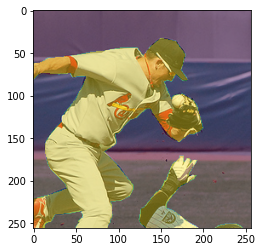

In [55]:
import tensorflow.keras.preprocessing.image as image
import matplotlib.pyplot as plt

iter = train_ds.__iter__()
eager_tensor=iter.get_next()

img = image.img_to_array(eager_tensor[0][0])
img_gt = image.img_to_array(eager_tensor[1][0])

plt.imshow(img)
plt.imshow(img_gt[...,0], alpha=0.4)

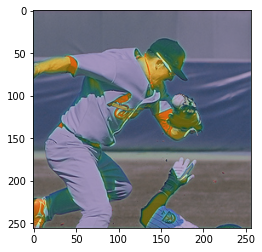

In [56]:
ds = Dataset()
def pred(img):
    out = model.predict(image.img_to_array(img)[None, ...])
    plt.imshow(out[0, ..., 0], alpha=0.4)


plt.imshow(img)
pred(img)
plt.show()